[51 序列模型](https://www.bilibili.com/video/BV1L44y1m768?spm_id_from=333.999.0.0)

- 序列数据



- 现实生活中很多数据都是有时序结构的，比如电影的评分（既不是固定的也不是随机的，会随着时间的变化而变化）
- 在统计学中，对超出已知观测范围进行预测称为外推法（extrapolation），在现有的观测值之间进行估计称为内插法（interpolation）

### 统计工具
- 在时间t观察到$x_t$，由于是实际序列，所以是有T个不独立的随机变量
$(x_1,...x_T) $~$ p(X)$
- 依据条件概率公式
$p(a,b) = p(a)p(b|a) = p(b)p(a|b)$
- <img src="picture\截屏2022-05-27 14.33.27.png"></a>
- 依据条件概率公式,可以得出如下结论:
- $$p(x)=p(x_1)\times p(x_2|x_1) \times p(x_3|x_2,x_1) \times *** p(x_T|x_{T-1},x_{T-2},...x_1)$$
- 当然我们也可以这么写,但是这么做实际上可能不可行,因为不可能使用未来的概率去反推过去的概率
- $$p(x)=p(x_T)\times p(x_{T-1}|x_T) \times p(x_{T-2}|x_{T-1},x_T) \times *** p(x_T|x_1,x_2,...x_{T-1})$$
- l理论上来说,只要我有所有时刻的条件概率,就能够知道现在时刻的概率


### 自回归模型（autoregressive models）
- 这里我们取出一个条件概率,并对其进行建模
- $p(x_T|x_{T-1},x_{T-2},...x_1) = p(x_T|f(x_1,x_2,...x_{T-1}))$
- 问题就转变成如何计算$f(x_1,x_2,...x_{T-1})$

### 经典马尔科夫假设
- <img src="picture/截屏2022-05-27 15.30.55.png"></a>
- 也就是当前概率至于$\tau$个时间点有关
- 那么公式也就转化为了$p(x_T)=p(x_T|x_{T-1},x_{T-2},...x_{T-\tau}) = p(x_T|f(x_{T-1},x_{T-2},...x_{T-\tau}))$
- 这里也就出现了可解决的方案:$f(x_{T-1},x_{T-2},...x_{T-\tau})$的数量是固定的$\tau$个,可以使用MLP来解决!

### 潜变量模型
- 直接将$f(x_T|x_{T-1},x_{T-2},...x_1)假设为h_t$
- $p(x_T)=p(x_T|x_{T-1},x_{T-2},...x_1) = p(x_T|h_t)$

In [86]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

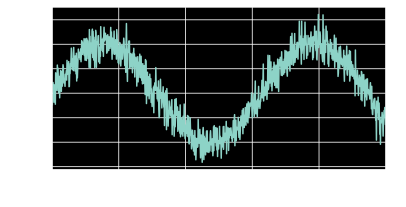

In [87]:
T = 1000
time = torch.arange(1,T+1,dtype = torch.float32)
x = torch.sin(0.01*time) +torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))


- 关键思想,构造数据对,和图片训练需要有图片和对应标签一样,时序模型同样需要构造数据对
- 按照马尔科夫模型,那么也可构造相应的键值对
- $y_t = X_t  以及  x_t = [X_{t-1},X_{t-2},...X_{t-\tau}]$


In [88]:
tau = 4
# 创建0矩阵
features = torch.zeros((T-tau,tau))
# 将t~t-tau时刻数据写入矩阵
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1,1))

# 0-600用于训练
batch_size, n_train = 16,600
# 只有前n_train个样本用于训练
# d2l的load_array本质上就是调用了datalodaer函数
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [89]:
# 构造996对数据
features.shape,labels.shape

(torch.Size([996, 4]), torch.Size([996, 1]))

In [90]:
# 我们这里创建了一个基本神经网络,由两个线性层,一个激活层实现
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        )
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [91]:
# 和以前没什么区别
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            # reduction='none'表示不加和,所以需要sum后反向传播
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.062079
epoch 2, loss: 0.056149
epoch 3, loss: 0.054471
epoch 4, loss: 0.052337
epoch 5, loss: 0.053327


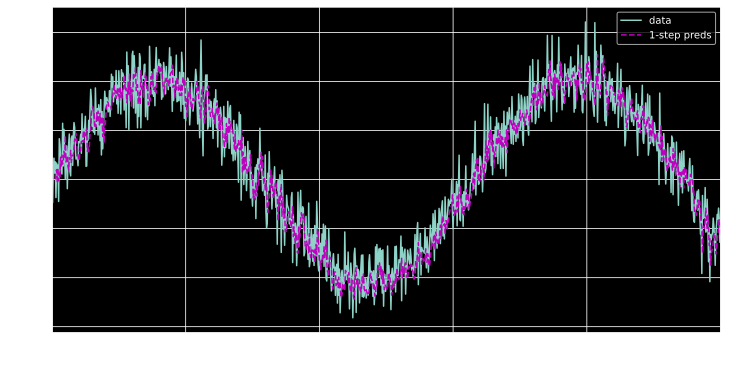

In [92]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(12, 6))

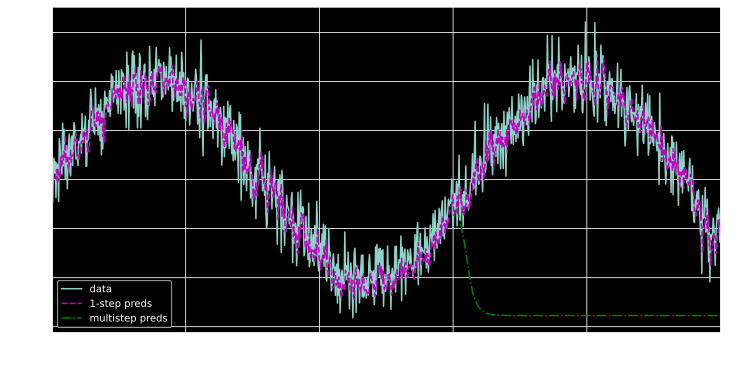

In [93]:
# 多步预测
# 前面预测效果好，是因为我们只预测下一时刻的数据
# 如果我们不在提供下一步的数据，而是让自己预测的数据作为输入数据，不断循环预测下去，会如何变化？
# 每次预测都会有误差，然后误差被不断累加，效果只会越来越差。
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(12, 6))

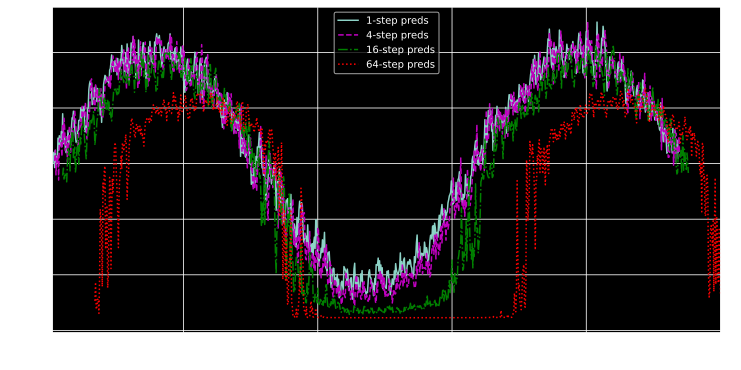

In [97]:
# max_steps是采用滑动窗口预测，max_steps是窗口的长度
# 可见预测较远的未来是非常困难的
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(12, 6))